In [2]:
import numpy as np
caffe_root = '../../'
import sys
sys.path.insert(0, caffe_root+'python')
import caffe

net = caffe.Net('deploy.prototxt','../base.caffemodel', caffe.TEST)

In [4]:
labels = open('/home/nine/datasets/cifar10/label.txt').readlines()
labels = [label.strip() for label in labels]

In [18]:
print label

truck



In [11]:
def makeLabelKeyDict() :
    dic = {}
    for i in range(0,10):
        dic[i] = []
    
    import lmdb
    env = lmdb.open('/home/nine/datasets/cifar10/cifar_train_lmdb')
    with env.begin() as txn:
        cursor = txn.cursor()
        for key,value in cursor : 
            datum = caffe.proto.caffe_pb2.Datum()
            datum.ParseFromString(value)
            dic[datum.label].append(key)
    return dic

label_key = makeLabelKeyDict()

In [23]:
def getImage(key):
    caffe_root = '../../'
    import lmdb
    
    imgs = [];
    
    img_preprocessed = np.zeros([32,32,3],np.float)
    env = lmdb.open('/home/nine/datasets/cifar10/cifar_train_lmdb')
    with env.begin() as txn:
        cursor = txn.cursor()
        value = cursor.get(key)
        datum = caffe.proto.caffe_pb2.Datum()
        datum.ParseFromString(value)
        
        label = datum.label
        img_preprocessed[:,:,0] = np.array(datum.float_data)[0:1024].reshape(32,32)
        img_preprocessed[:,:,1] = np.array(datum.float_data)[1024:2048].reshape(32,32)
        img_preprocessed[:,:,2] = np.array(datum.float_data)[2048:].reshape(32,32)
        
    return (label,img_preprocessed)

def getActivation(keys):
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2,0,1))
    
    ret = {};
    ret['raw'] = {'loss' : np.zeros((len(keys),10)), 'pool3' : np.zeros((len(keys),10))}
    ret['avg'] = {'loss' : np.zeros(10), 'pool3' : np.zeros(10)}
    for i in range(0,len(keys),10):
        data = [];
        cnt = min(i+10,len(keys))-i;
        for j in range(i,i+cnt):
            label,preprocessed = getImage(keys[j]);
            data.append(transformer.preprocess('data',preprocessed))
        ret['raw']['loss'][i:i+cnt,:] = net.forward_all(data=np.asarray(data))['loss'].reshape(cnt,10)
        ret['raw']['pool3'][i:i+cnt,:] = net.blobs['pool3'].data[0:cnt,:,:,:].reshape(cnt,10)
    ret['avg']['pool3'] = np.sum(ret['raw']['pool3'],axis=0) / len(keys)
    return ret

airplane


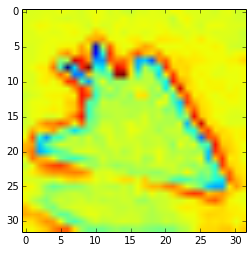

automobile


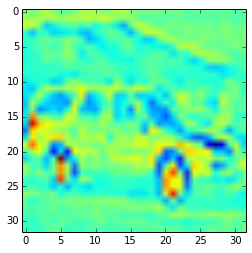

bird


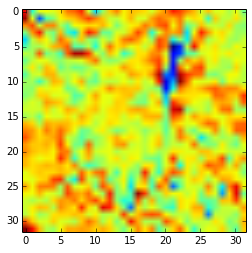

cat


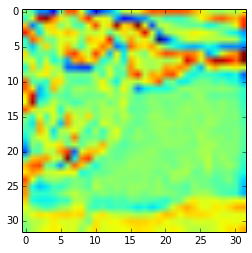

deer


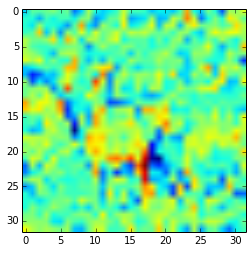

dog


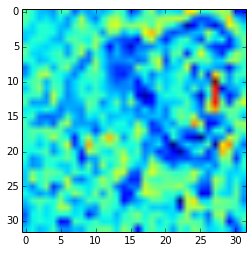

frog


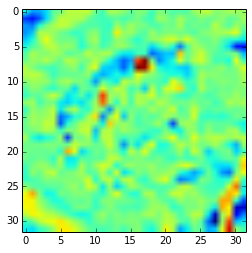

horse


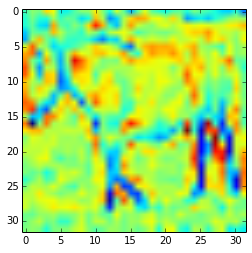

ship


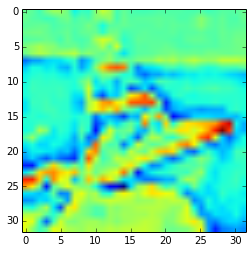

truck


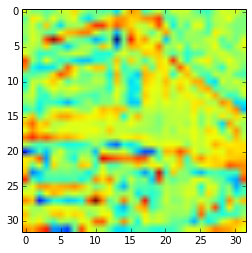

In [25]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# Turn interactive plotting off

for i in range(0,10):
    label,image = getImage(label_key[i][0])
    print labels[label]
    plt.imshow(image[:,:,0])
    plt.show()

In [26]:
activations = np.zeros((10,10),np.float);
for i in range(0,10):
    activations[i,:] = getActivation(label_key[i][0:500])['avg']['pool3'];

In [29]:
import sklearn.cluster as clu
NUM_CLUSTER = 5

#from sklearn.neighbors import kneighbors_graph
#connectivity = kneighbors_graph(activations, n_neighbors=5)
#ward = clu.AgglomerativeClustering(n_clusters=NUM_CLUSTER,connectivity=connectivity).fit(activations)
ward = clu.AgglomerativeClustering(n_clusters=NUM_CLUSTER).fit(activations)
super_category = ward.labels_
for i in range(0,NUM_CLUSTER):
    for j in range(0,10):
        if super_category[j] == i:
            print labels[j], 
    print

for i in range(0,NUM_CLUSTER):
    print 'children {'
    for j in range(0,10):
        if super_category[j] == i:
            print '\tchildren {\n\t\tlabel:%d #%s\n\t}'%(j,labels[j])
    print '}'

airplane ship
deer horse
automobile truck
bird frog
cat dog
children {
	children {
		label:0 #airplane
	}
	children {
		label:8 #ship
	}
}
children {
	children {
		label:4 #deer
	}
	children {
		label:7 #horse
	}
}
children {
	children {
		label:1 #automobile
	}
	children {
		label:9 #truck
	}
}
children {
	children {
		label:2 #bird
	}
	children {
		label:6 #frog
	}
}
children {
	children {
		label:3 #cat
	}
	children {
		label:5 #dog
	}
}
